In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import phate
import scprep

(1000, 10)


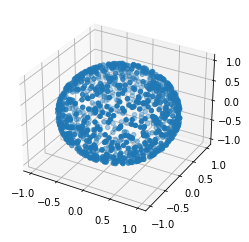

In [17]:

#Generate sphere

sphere = []
for i in range(1000):
    x = np.random.normal(0,1,3)
    sphere.append(x/(np.sqrt(np.sum(x**2))))
   
nsphere = np.array(sphere)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nsphere[:,0], nsphere[:,1], nsphere[:,2])

zerovec = np.zeros((1000,7))

highdsphere = np.concatenate((nsphere,zerovec),axis=1)
print(highdsphere.shape)




In [24]:
#Run PHATE on sphere

phate_operator = phate.PHATE(random_state=42)
phate_sphere = phate_operator.fit_transform(highdsphere)

Calculating PHATE...
  Running PHATE on 1000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 0.10 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.59 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.03 seconds.
Calculated PHATE in 1.81 seconds.


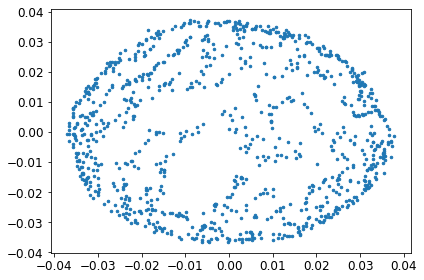

In [25]:
#Visualize high dimensional sphere with PHATE

cax = scprep.plot.scatter2d(phate_sphere)



In [26]:
#rotate sphere to higher dimensions

print(phate_sphere)
X = torch.tensor(highdsphere, requires_grad=True)

[[ 0.01034491  0.01816526]
 [-0.00963288 -0.02896925]
 [-0.0152004   0.02318738]
 ...
 [-0.01373158  0.01592911]
 [ 0.01797715 -0.02862811]
 [-0.0242948   0.01538252]]


In [20]:
#Define Phate function



def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    log_p = torch.log(pt)
    return pt


In [21]:
#Define Autoencoder class

import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_layer=[10, 10, 10],
        decoder_layer=[10, 10, 10],
        activation="ReLU",
        use_cuda=False,
    ) -> None:
        super().__init__()
        device = "cuda" if use_cuda else "cpu"
        encoder = []
        for i0, i1 in zip(encoder_layer, encoder_layer[1:]):
            encoder.append(nn.Linear(i0, i1))
            if i1 == 10:
                encoder.append(getattr(nn, "ReLU")())
            else:
                encoder.append(getattr(nn, "ReLU")())
        print(encoder)
        self.encoder = nn.Sequential(*encoder).to(device)
        # decoder=[]
        # for i0,i1 in zip(decoder_layer,decoder_layer[1:]):
        #   decoder.append(nn.Linear(i0, i1))
        #   decoder.append(getattr(nn, activation)())
        # self.decoder = nn.Sequential(*decoder).to(device)

    # def encode(self,x):
    #   return self.encoder(x)

    # def decoder(self,x):
    #   return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        return x  # self.decoder(x)

In [22]:

use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 2], decoder_layer=[10, 10, 10], use_cuda=use_cuda
)
optimizer = torch.optim.AdamW(phate_ae.parameters(), lr=0.000001)


n_epochs = 5000
n = 800

# Get 100 random indices
fullind = np.arange(nsphere.shape[0])
random_indices = np.random.choice(
    fullind, size=n, replace=False
)  


for epoch in range(n_epochs):
    np.random.shuffle(random_indices)
    optimizer.zero_grad()

    X_sample = X[random_indices].float()  # Get 100 samples
    P = torch_phate(X_sample).cuda()  # Get log proability

    noise = (
        (0.05 * torch.randn(X_sample.size())).cuda()
        if use_cuda
        else 0.05 * torch.randn(X_sample.size())
    )  # define noise from Gaussina distribution
    
    encode_sample = phate_ae.forward(
        X_sample.cuda() + noise.cuda()
    )  # encode phate into 2 dimensions

    loss = nn.MSELoss()(
        torch.cdist(encode_sample, encode_sample) ** 2, torch.cdist(P, P) ** 2
    )  # Loss between encoded space and diffusion distance

    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Loss distance :", loss)




[Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=2, bias=True), ReLU()]
Loss distance : tensor(3.7170e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(3.5098e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(3.3103e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(3.2836e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(3.1918e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(2.9527e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(2.7095e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(2.5760e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(2.5229e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
Loss distance : tensor(2.3654e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


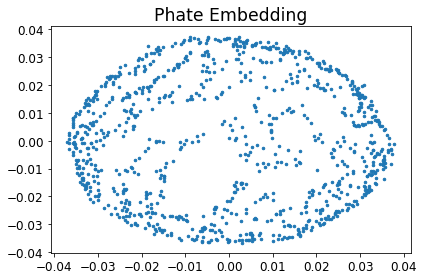

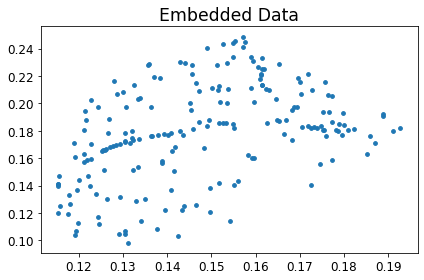

In [30]:

# Get test indices
testind = []
fullind = list(np.arange(highdsphere.shape[0]))
for i in fullind:
    if i not in random_indices:
        testind.append(i)

testind = np.array(testind)

# Get samples from autoencoder
nxsample = phate_ae.encoder(X[testind].float().cuda())
xsampout = nxsample.detach().cpu().numpy()

# Visualize ground truth
cax = scprep.plot.scatter2d(
    phate_sphere, title= "Phate Embedding"
)


# Visualize Embedding
cax = scprep.plot.scatter2d(xsampout, title="Embedded Data")


# Compute Jacobian
Jacob = []
for i in testind:
    X_sample = X[i].float().cuda()
    J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample).squeeze()
    Jacob.append(J.cpu().detach().numpy())

# Compute FIM
FIM = []
for i in range(testind.shape[0]):
    FIM.append( (Jacob[i] @ Jacob[i].T) * np.exp(xsampout[i, :]))







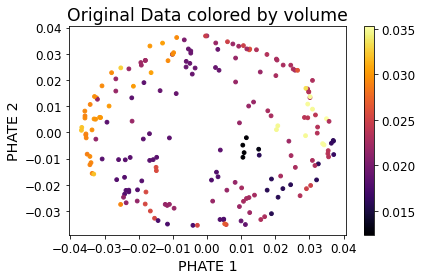

In [31]:
#Compute Volume
V = np.sqrt(np.linalg.det(FIM))

#Visualize Original PHATE data with volume measurement
# Visualize ground truth
cax = scprep.plot.scatter2d(
    phate_sphere[testind],
    c=V,
    title="Original Data colored by volume",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)
